# Setup

In [2]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
sns.set()
from tensorflow.keras import *
from tensorflow.keras.layers import *
from sklearn import preprocessing, model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

In [3]:
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)

#Load all data
data = pd.read_csv('data/updated_with_R.csv')

#Extract labels
y = data[['chord']]
tx = data.drop(columns=['Unnamed: 0'])

#Only keep the chords???
#tx = y

#Use one-hot encoding/dummy variabes for categorical values
y = pd.get_dummies(y)
tx = pd.get_dummies(tx)

#Replace Nans with zero, since x*nan = nan
tx = tx.replace(np.nan, 0)

#Standardize it? 
#tx = (tx-tx.mean())/tx.std()

#Split the data into training and test sets
#Since order is important, shuffle = False, but we should probably split on the moments or something similar
train_x, test_x, train_y, test_y = model_selection.train_test_split(tx, y, test_size = 0.1, shuffle = False)

# Data exploration

# Helper Functions

In [4]:
def disp_results(history_object):
    """
    Takes a history object and plots the evolution of the metrics as well as the final scores
    """
    history = history_object
    df = pd.DataFrame({'epochs': history.epoch,
                       'accuracy': history.history['acc'],
                       'validation_accuracy': history.history['val_acc'],
                       'loss': history.history['loss'], 
                       'val_loss': history.history['val_loss']})


    #Plot the the scores on the validation and training sets
    df.plot(x='epochs', y = ['validation_accuracy','accuracy'], figsize=[15,5])
    df.plot(x='epochs', y = ['val_loss','loss'], figsize=[15,5])

    a = history.history['acc'][-1]
    va= history.history['val_acc'][-1]
    l = history.history['loss'][-1]
    vl= history.history['val_loss'][-1]

    print("Final values\nacc\n{}\nvalacc\n{}\nloss\n{}\nvaloss\n{}\n".format(a, va, l, vl))
    
    print(history.model.summary())
    plt.show()

In [5]:
def generate_sequences(train_x, train_y, seq_length):
    """
    Input:
        train_x, train_y: the data we want to transform into sequences
        seq_length: the length of the sequences
    Return:
        lstm_x: a matrix where elements are on the form (sequence, sequence length, features)
        lstm_y: a matrix where elements are on the form (sequence, classes)
    Notes: 
        Does not generate sequences for the last (seq_length - 1) datapoints
        Takes quite a lot of computing with long sequence lengths.
        
        
    """
    #containers for the sequences we generate
    lstm_input = []
    lstm_output = []
    
    for i in range(0, train_x.shape[0] - (seq_length +1)):
        #Create a sequence
        in_data = train_x.iloc[i:seq_length + i].values
        lstm_input.append(in_data)
        
        #Select the chord that would have appeared after the sequence
        out_data = train_y.iloc[seq_length + i].values
        lstm_output.append(out_data) 

    #Convert to arrays
    lstm_x = np.array(lstm_input)
    lstm_y = np.array(lstm_output)
    
    return lstm_x, lstm_y

# Models

In [6]:
def lstm(lstm_x, lstm_y, optimizer, loss, metrics):
    """
    A LSTM, a neural network operating on sequences to predict next items in a sequence.
    Needs some data preprocessing to generate sequences
    """
    # Input layers
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=(lstm_x.shape[1], lstm_x.shape[2]))) 
    model.add(Dropout(0.3))
    model.add(LSTM(512, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(256))
    model.add(Dense(256))
    model.add(Dropout(0.3))
    model.add(Activation('softmax')) 
    
    #Output layers
    model.add(Dense(lstm_y.shape[1], activation='softmax'))

    #Hyperparameters
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)
    return model

In [7]:
def lstm2(lstm_x, lstm_y, optimizer, loss, metrics):
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=(lstm_x.shape[1], lstm_x.shape[2])))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(128, return_sequences=True),input_shape=(lstm_x.shape[1],lstm_x.shape[2])))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(lstm_y.shape[1], activation='softmax'))

    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)
    return model



In [8]:
def lstm3(lstm_x, lstm_y, optimizer, loss, metrics):
    #Based on https://arxiv.org/pdf/1712.01011.pdf
    model = Sequential()
    model.add(TimeDistributed(Dense(12), input_shape=(lstm_x.shape[1], lstm_x.shape[2])))
    model.add(Bidirectional(LSTM(128, return_sequences=True, activation='tanh')))
    model.add(Bidirectional(LSTM(128, return_sequences=False, activation='tanh')))
    model.add(Dense(lstm_y.shape[1], activation='softmax'))

    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)
    return model

# Train

## Setup

In [9]:
#Define model parameters
optimizer = optimizers.Adam()
loss = 'categorical_crossentropy'
metrics = ['accuracy']
callbacks_list = []  

In [ ]:
#Run this cell only if you want to checkpoint progress
checkpoint = ModelCheckpoint(
    'weights.{epoch:02d}-{val_loss:.2f}.hdf5',
    monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)

callbacks_list = [checkpoint]     

In [ ]:
#Run this cell to load saved weights
#model.load_weights('weights.10-4.13.hdf5')

## Fit

In [10]:
# Generate the sequences for the lstm
lstm_x, lstm_y = generate_sequences(train_x, train_y, 10)

#Generate model
model = lstm2(lstm_x, lstm_y, optimizer, loss, metrics)
    
#Train on it and save metrics at each epoch
history = model.fit(lstm_x,
                    lstm_y,
                    epochs = 100,
                    verbose = 1,
                    validation_split = 0.1, 
                    callbacks = callbacks_list)

h1 = history

Train on 22746 samples, validate on 2528 samples
Epoch 1/100
22746/22746 [==============================] - 175s 8ms/step - loss: 3.5930 - acc: 0.1084 - val_loss: 3.6007 - val_acc: 0.1021
Epoch 2/100
22746/22746 [==============================] - 171s 8ms/step - loss: 3.5470 - acc: 0.1182 - val_loss: 3.6369 - val_acc: 0.1021
Epoch 3/100
22746/22746 [==============================] - 153s 7ms/step - loss: 3.5397 - acc: 0.1185 - val_loss: 3.5981 - val_acc: 0.1021
Epoch 4/100
22746/22746 [==============================] - 154s 7ms/step - loss: 3.5302 - acc: 0.1173 - val_loss: 3.6081 - val_acc: 0.1017
Epoch 5/100
22746/22746 [==============================] - 154s 7ms/step - loss: 3.5240 - acc: 0.1187 - val_loss: 3.5859 - val_acc: 0.1274
Epoch 6/100
22746/22746 [==============================] - 154s 7ms/step - loss: 3.5012 - acc: 0.1245 - val_loss: 3.4704 - val_acc: 0.1570
Epoch 7/100
22746/22746 [==============================] - 154s 7ms/step - loss: 3.4199 - acc: 0.1385 - val_loss: 3.3

22746/22746 [==============================] - 153s 7ms/step - loss: 2.8241 - acc: 0.2571 - val_loss: 3.1027 - val_acc: 0.2199
Epoch 60/100
22746/22746 [==============================] - 153s 7ms/step - loss: 2.8246 - acc: 0.2585 - val_loss: 3.0744 - val_acc: 0.2195
Epoch 61/100
22746/22746 [==============================] - 152s 7ms/step - loss: 2.8213 - acc: 0.2565 - val_loss: 3.1182 - val_acc: 0.2089
Epoch 62/100
22746/22746 [==============================] - 153s 7ms/step - loss: 2.8040 - acc: 0.2590 - val_loss: 3.1032 - val_acc: 0.2203
Epoch 63/100
22746/22746 [==============================] - 153s 7ms/step - loss: 2.8004 - acc: 0.2611 - val_loss: 3.1641 - val_acc: 0.2057
Epoch 64/100
22746/22746 [==============================] - 153s 7ms/step - loss: 2.7994 - acc: 0.2637 - val_loss: 3.1037 - val_acc: 0.2231
Epoch 65/100
22746/22746 [==============================] - 153s 7ms/step - loss: 2.7847 - acc: 0.2650 - val_loss: 3.0890 - val_acc: 0.2278
Epoch 66/100
22746/22746 [=======

In [11]:
#Generate model
model = lstm2(lstm_x, lstm_y, optimizer, loss, metrics)
    
#Train on it and save metrics at each epoch
history = model.fit(lstm_x,
                    lstm_y,
                    epochs = 100,
                    verbose = 1,
                    validation_split = 0.2, 
                    callbacks = callbacks_list)

h2 = history

Train on 20219 samples, validate on 5055 samples
Epoch 1/100
20219/20219 [==============================] - 144s 7ms/step - loss: 3.5576 - acc: 0.1203 - val_loss: 3.6290 - val_acc: 0.0944
Epoch 2/100
20219/20219 [==============================] - 140s 7ms/step - loss: 3.5293 - acc: 0.1240 - val_loss: 3.6412 - val_acc: 0.0944
Epoch 3/100
20219/20219 [==============================] - 140s 7ms/step - loss: 3.5229 - acc: 0.1253 - val_loss: 3.6324 - val_acc: 0.0944
Epoch 4/100
20219/20219 [==============================] - 140s 7ms/step - loss: 3.5134 - acc: 0.1250 - val_loss: 3.6771 - val_acc: 0.0944
Epoch 5/100
20219/20219 [==============================] - 140s 7ms/step - loss: 3.4995 - acc: 0.1262 - val_loss: 3.5930 - val_acc: 0.1001
Epoch 6/100
20219/20219 [==============================] - 140s 7ms/step - loss: 3.4528 - acc: 0.1309 - val_loss: 3.5878 - val_acc: 0.1104
Epoch 7/100
20219/20219 [==============================] - 140s 7ms/step - loss: 3.3988 - acc: 0.1410 - val_loss: 3.4

20219/20219 [==============================] - 140s 7ms/step - loss: 2.9179 - acc: 0.2338 - val_loss: 3.2308 - val_acc: 0.1899
Epoch 60/100
20219/20219 [==============================] - 140s 7ms/step - loss: 2.9011 - acc: 0.2369 - val_loss: 3.2051 - val_acc: 0.2045
Epoch 61/100
20219/20219 [==============================] - 140s 7ms/step - loss: 2.9028 - acc: 0.2369 - val_loss: 3.2469 - val_acc: 0.1955
Epoch 62/100
20219/20219 [==============================] - 140s 7ms/step - loss: 2.9125 - acc: 0.2320 - val_loss: 3.2294 - val_acc: 0.1960
Epoch 63/100
20219/20219 [==============================] - 140s 7ms/step - loss: 2.8974 - acc: 0.2412 - val_loss: 3.2071 - val_acc: 0.2053
Epoch 64/100
20219/20219 [==============================] - 148s 7ms/step - loss: 2.8873 - acc: 0.2420 - val_loss: 3.2092 - val_acc: 0.2059
Epoch 65/100
20219/20219 [==============================] - 165s 8ms/step - loss: 2.8705 - acc: 0.2465 - val_loss: 3.2007 - val_acc: 0.2020
Epoch 66/100
20219/20219 [=======

In [12]:
#Generate model
model = lstm2(lstm_x, lstm_y, optimizer, loss, metrics)
    
#Train on it and save metrics at each epoch
history = model.fit(lstm_x,
                    lstm_y,
                    epochs = 100,
                    verbose = 1,
                    validation_split = 0.3, 
                    callbacks = callbacks_list)

h3 = history

Train on 17691 samples, validate on 7583 samples
Epoch 1/100
17691/17691 [==============================] - 133s 8ms/step - loss: 3.5677 - acc: 0.1160 - val_loss: 3.5930 - val_acc: 0.1075
Epoch 2/100
17691/17691 [==============================] - 128s 7ms/step - loss: 3.5358 - acc: 0.1235 - val_loss: 3.5849 - val_acc: 0.1075
Epoch 3/100
17691/17691 [==============================] - 129s 7ms/step - loss: 3.5309 - acc: 0.1240 - val_loss: 3.5894 - val_acc: 0.1075
Epoch 4/100
17691/17691 [==============================] - 129s 7ms/step - loss: 3.5209 - acc: 0.1239 - val_loss: 3.6015 - val_acc: 0.1075
Epoch 5/100
17691/17691 [==============================] - 129s 7ms/step - loss: 3.5156 - acc: 0.1229 - val_loss: 3.6070 - val_acc: 0.1075
Epoch 6/100
17691/17691 [==============================] - 129s 7ms/step - loss: 3.5117 - acc: 0.1232 - val_loss: 3.6015 - val_acc: 0.1075
Epoch 7/100
17691/17691 [==============================] - 129s 7ms/step - loss: 3.5065 - acc: 0.1240 - val_loss: 3.5

17691/17691 [==============================] - 127s 7ms/step - loss: 2.9912 - acc: 0.2123 - val_loss: 3.2056 - val_acc: 0.1997
Epoch 60/100
17691/17691 [==============================] - 127s 7ms/step - loss: 2.9899 - acc: 0.2150 - val_loss: 3.2212 - val_acc: 0.1998
Epoch 61/100
17691/17691 [==============================] - 127s 7ms/step - loss: 2.9932 - acc: 0.2120 - val_loss: 3.2181 - val_acc: 0.1881
Epoch 62/100
17691/17691 [==============================] - 127s 7ms/step - loss: 2.9866 - acc: 0.2132 - val_loss: 3.2052 - val_acc: 0.2024
Epoch 63/100
17691/17691 [==============================] - 127s 7ms/step - loss: 2.9746 - acc: 0.2174 - val_loss: 3.2064 - val_acc: 0.1989
Epoch 64/100
17691/17691 [==============================] - 127s 7ms/step - loss: 2.9739 - acc: 0.2159 - val_loss: 3.2530 - val_acc: 0.1836
Epoch 65/100
17691/17691 [==============================] - 127s 7ms/step - loss: 2.9632 - acc: 0.2201 - val_loss: 3.2478 - val_acc: 0.1883
Epoch 66/100
17691/17691 [=======

In [13]:
#Generate model
model = lstm2(lstm_x, lstm_y, optimizer, loss, metrics)
    
#Train on it and save metrics at each epoch
history = model.fit(lstm_x,
                    lstm_y,
                    epochs = 100,
                    verbose = 1,
                    validation_split = 0.4, 
                    callbacks = callbacks_list)

h4 = history

Train on 15164 samples, validate on 10110 samples
Epoch 1/100
15164/15164 [==============================] - 121s 8ms/step - loss: 3.5624 - acc: 0.1193 - val_loss: 3.6021 - val_acc: 0.1072
Epoch 2/100
15164/15164 [==============================] - 116s 8ms/step - loss: 3.5287 - acc: 0.1254 - val_loss: 3.6213 - val_acc: 0.1072
Epoch 3/100
15164/15164 [==============================] - 116s 8ms/step - loss: 3.5216 - acc: 0.1267 - val_loss: 3.6110 - val_acc: 0.1072
Epoch 4/100
15164/15164 [==============================] - 117s 8ms/step - loss: 3.5106 - acc: 0.1266 - val_loss: 3.6069 - val_acc: 0.1072
Epoch 5/100
15164/15164 [==============================] - 117s 8ms/step - loss: 3.5048 - acc: 0.1261 - val_loss: 3.6094 - val_acc: 0.1072
Epoch 6/100
15164/15164 [==============================] - 117s 8ms/step - loss: 3.4985 - acc: 0.1266 - val_loss: 3.6053 - val_acc: 0.1072
Epoch 7/100
15164/15164 [==============================] - 117s 8ms/step - loss: 3.4932 - acc: 0.1265 - val_loss: 3.

15164/15164 [==============================] - 116s 8ms/step - loss: 3.0291 - acc: 0.1991 - val_loss: 3.2609 - val_acc: 0.1858
Epoch 60/100
15164/15164 [==============================] - 115s 8ms/step - loss: 3.0212 - acc: 0.2006 - val_loss: 3.2771 - val_acc: 0.1856
Epoch 61/100
15164/15164 [==============================] - 115s 8ms/step - loss: 3.0116 - acc: 0.2025 - val_loss: 3.2517 - val_acc: 0.1927
Epoch 62/100
15164/15164 [==============================] - 115s 8ms/step - loss: 2.9993 - acc: 0.2065 - val_loss: 3.2660 - val_acc: 0.1854
Epoch 63/100
15164/15164 [==============================] - 115s 8ms/step - loss: 3.0094 - acc: 0.2031 - val_loss: 3.2429 - val_acc: 0.1887
Epoch 64/100
15164/15164 [==============================] - 116s 8ms/step - loss: 2.9994 - acc: 0.2054 - val_loss: 3.2662 - val_acc: 0.1882
Epoch 65/100
15164/15164 [==============================] - 115s 8ms/step - loss: 2.9833 - acc: 0.2091 - val_loss: 3.2718 - val_acc: 0.1882
Epoch 66/100
15164/15164 [=======

In [14]:
#Generate model
model = lstm2(lstm_x, lstm_y, optimizer, loss, metrics)
    
#Train on it and save metrics at each epoch
history = model.fit(lstm_x,
                    lstm_y,
                    epochs = 100,
                    verbose = 1,
                    validation_split = 0.5, 
                    callbacks = callbacks_list)

h5 = history

Train on 12637 samples, validate on 12637 samples
Epoch 1/100
12637/12637 [==============================] - 109s 9ms/step - loss: 3.5660 - acc: 0.1158 - val_loss: 3.6079 - val_acc: 0.1136
Epoch 2/100
12637/12637 [==============================] - 103s 8ms/step - loss: 3.5319 - acc: 0.1215 - val_loss: 3.6022 - val_acc: 0.1136
Epoch 3/100
12637/12637 [==============================] - 104s 8ms/step - loss: 3.5234 - acc: 0.1206 - val_loss: 3.6054 - val_acc: 0.1136
Epoch 4/100
12637/12637 [==============================] - 104s 8ms/step - loss: 3.5192 - acc: 0.1235 - val_loss: 3.6000 - val_acc: 0.1136
Epoch 5/100
12637/12637 [==============================] - 104s 8ms/step - loss: 3.5166 - acc: 0.1250 - val_loss: 3.6073 - val_acc: 0.1136
Epoch 6/100
12637/12637 [==============================] - 104s 8ms/step - loss: 3.5136 - acc: 0.1245 - val_loss: 3.6120 - val_acc: 0.1131
Epoch 7/100
12637/12637 [==============================] - 104s 8ms/step - loss: 3.5086 - acc: 0.1260 - val_loss: 3.

12637/12637 [==============================] - 116s 9ms/step - loss: 3.2120 - acc: 0.1648 - val_loss: 3.4747 - val_acc: 0.1635
Epoch 60/100
12637/12637 [==============================] - 104s 8ms/step - loss: 3.2038 - acc: 0.1634 - val_loss: 3.4911 - val_acc: 0.1608
Epoch 61/100
12637/12637 [==============================] - 103s 8ms/step - loss: 3.2027 - acc: 0.1640 - val_loss: 3.5076 - val_acc: 0.1580
Epoch 62/100
12637/12637 [==============================] - 103s 8ms/step - loss: 3.2067 - acc: 0.1616 - val_loss: 3.5031 - val_acc: 0.1610
Epoch 63/100
12637/12637 [==============================] - 103s 8ms/step - loss: 3.1940 - acc: 0.1653 - val_loss: 3.4939 - val_acc: 0.1612
Epoch 64/100
12637/12637 [==============================] - 103s 8ms/step - loss: 3.1993 - acc: 0.1622 - val_loss: 3.5239 - val_acc: 0.1617
Epoch 65/100
12637/12637 [==============================] - 103s 8ms/step - loss: 3.1861 - acc: 0.1675 - val_loss: 3.5070 - val_acc: 0.1597
Epoch 66/100
12637/12637 [=======

In [15]:
#Generate model
model = lstm2(lstm_x, lstm_y, optimizer, loss, metrics)
    
#Train on it and save metrics at each epoch
history = model.fit(lstm_x,
                    lstm_y,
                    epochs = 100,
                    verbose = 1,
                    validation_split = 0.6, 
                    callbacks = callbacks_list)

h6 = history

Train on 10109 samples, validate on 15165 samples
Epoch 1/100
10109/10109 [==============================] - 96s 10ms/step - loss: 3.5470 - acc: 0.1183 - val_loss: 3.6040 - val_acc: 0.1144
Epoch 2/100
10109/10109 [==============================] - 90s 9ms/step - loss: 3.5047 - acc: 0.1260 - val_loss: 3.5972 - val_acc: 0.1144
Epoch 3/100
10109/10109 [==============================] - 90s 9ms/step - loss: 3.5016 - acc: 0.1263 - val_loss: 3.5934 - val_acc: 0.1144
Epoch 4/100
10109/10109 [==============================] - 90s 9ms/step - loss: 3.5019 - acc: 0.1262 - val_loss: 3.5933 - val_acc: 0.1144
Epoch 5/100
10109/10109 [==============================] - 90s 9ms/step - loss: 3.4954 - acc: 0.1259 - val_loss: 3.5969 - val_acc: 0.1144
Epoch 6/100
10109/10109 [==============================] - 90s 9ms/step - loss: 3.4945 - acc: 0.1262 - val_loss: 3.5957 - val_acc: 0.1144
Epoch 7/100
10109/10109 [==============================] - 90s 9ms/step - loss: 3.4945 - acc: 0.1263 - val_loss: 3.5973 -

10109/10109 [==============================] - 90s 9ms/step - loss: 3.2984 - acc: 0.1480 - val_loss: 3.5191 - val_acc: 0.1362
Epoch 60/100
10109/10109 [==============================] - 89s 9ms/step - loss: 3.3028 - acc: 0.1477 - val_loss: 3.4797 - val_acc: 0.1401
Epoch 61/100
10109/10109 [==============================] - 89s 9ms/step - loss: 3.2948 - acc: 0.1491 - val_loss: 3.5289 - val_acc: 0.1362
Epoch 62/100
10109/10109 [==============================] - 89s 9ms/step - loss: 3.2953 - acc: 0.1485 - val_loss: 3.5061 - val_acc: 0.1368
Epoch 63/100
10109/10109 [==============================] - 90s 9ms/step - loss: 3.2946 - acc: 0.1476 - val_loss: 3.5079 - val_acc: 0.1368
Epoch 64/100
10109/10109 [==============================] - 89s 9ms/step - loss: 3.2909 - acc: 0.1477 - val_loss: 3.5070 - val_acc: 0.1368
Epoch 65/100
10109/10109 [==============================] - 90s 9ms/step - loss: 3.2946 - acc: 0.1484 - val_loss: 3.5097 - val_acc: 0.1381
Epoch 66/100
10109/10109 [==============

In [16]:
#Generate model
model = lstm2(lstm_x, lstm_y, optimizer, loss, metrics)
    
#Train on it and save metrics at each epoch
history = model.fit(lstm_x,
                    lstm_y,
                    epochs = 100,
                    verbose = 1,
                    validation_split = 0.7, 
                    callbacks = callbacks_list)

h7 = history

Train on 7582 samples, validate on 17692 samples
Epoch 1/100
7582/7582 [==============================] - 84s 11ms/step - loss: 3.5517 - acc: 0.1084 - val_loss: 3.6102 - val_acc: 0.1161
Epoch 2/100
7582/7582 [==============================] - 77s 10ms/step - loss: 3.4985 - acc: 0.1220 - val_loss: 3.6138 - val_acc: 0.1161
Epoch 3/100
7582/7582 [==============================] - 77s 10ms/step - loss: 3.4946 - acc: 0.1220 - val_loss: 3.6019 - val_acc: 0.1161
Epoch 4/100
7582/7582 [==============================] - 77s 10ms/step - loss: 3.4944 - acc: 0.1254 - val_loss: 3.6097 - val_acc: 0.1161
Epoch 5/100
7582/7582 [==============================] - 77s 10ms/step - loss: 3.4854 - acc: 0.1257 - val_loss: 3.6104 - val_acc: 0.1161
Epoch 6/100
7582/7582 [==============================] - 77s 10ms/step - loss: 3.4854 - acc: 0.1253 - val_loss: 3.6114 - val_acc: 0.1161
Epoch 7/100
7582/7582 [==============================] - 77s 10ms/step - loss: 3.4856 - acc: 0.1254 - val_loss: 3.6092 - val_acc:

7582/7582 [==============================] - 76s 10ms/step - loss: 3.2961 - acc: 0.1418 - val_loss: 3.6390 - val_acc: 0.1349
Epoch 61/100
7582/7582 [==============================] - 77s 10ms/step - loss: 3.2890 - acc: 0.1436 - val_loss: 3.6699 - val_acc: 0.1348
Epoch 62/100
7582/7582 [==============================] - 77s 10ms/step - loss: 3.2816 - acc: 0.1435 - val_loss: 3.6104 - val_acc: 0.1378
Epoch 63/100
7582/7582 [==============================] - 77s 10ms/step - loss: 3.2869 - acc: 0.1438 - val_loss: 3.6204 - val_acc: 0.1377
Epoch 64/100
7582/7582 [==============================] - 77s 10ms/step - loss: 3.2839 - acc: 0.1464 - val_loss: 3.6282 - val_acc: 0.1368
Epoch 65/100
7582/7582 [==============================] - 77s 10ms/step - loss: 3.2810 - acc: 0.1464 - val_loss: 3.5424 - val_acc: 0.1410
Epoch 66/100
7582/7582 [==============================] - 76s 10ms/step - loss: 3.2833 - acc: 0.1431 - val_loss: 3.6108 - val_acc: 0.1356
Epoch 67/100
7582/7582 [=======================

Final values
acc
0.49239426712651035
valacc
0.1550632911392405
loss
1.7760235407647404
valoss
4.107802436321596

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_161 (LSTM)              (None, 10, 256)           339968    
_________________________________________________________________
dropout_100 (Dropout)        (None, 10, 256)           0         
_________________________________________________________________
bidirectional_58 (Bidirectio (None, 10, 256)           394240    
_________________________________________________________________
lstm_163 (LSTM)              (None, 64)                82176     
_________________________________________________________________
dropout_101 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_58 (Dense)             (None, 75)                4875      
Total params: 821,259
Trainab

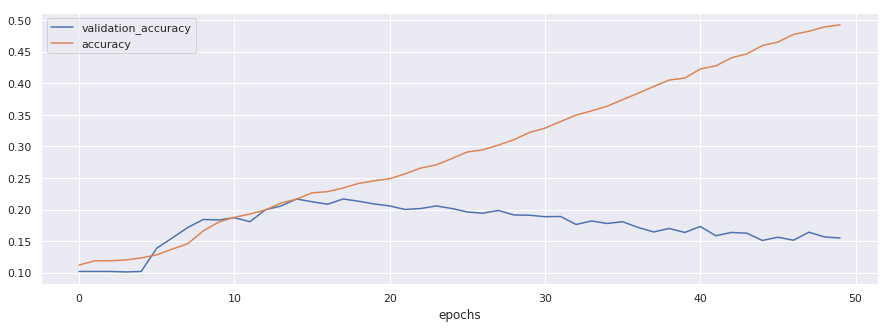

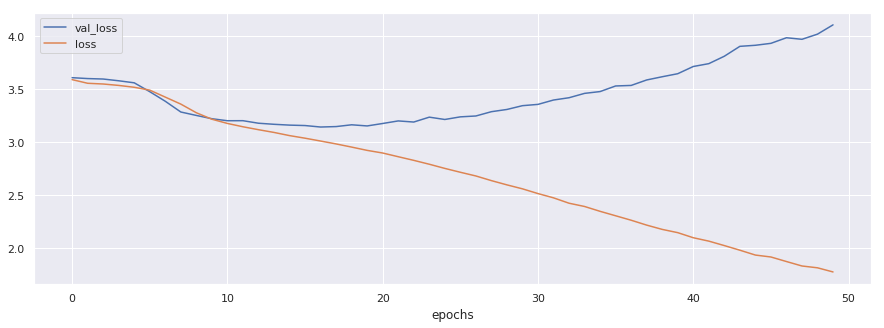

Final values
acc
0.43192047085899515
valacc
0.15727002963821682
loss
2.077411927256647
valoss
4.109327515933209

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_164 (LSTM)              (None, 10, 256)           339968    
_________________________________________________________________
dropout_102 (Dropout)        (None, 10, 256)           0         
_________________________________________________________________
bidirectional_59 (Bidirectio (None, 10, 256)           394240    
_________________________________________________________________
lstm_166 (LSTM)              (None, 64)                82176     
_________________________________________________________________
dropout_103 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_59 (Dense)             (None, 75)                4875      
Total params: 821,259
Trainab

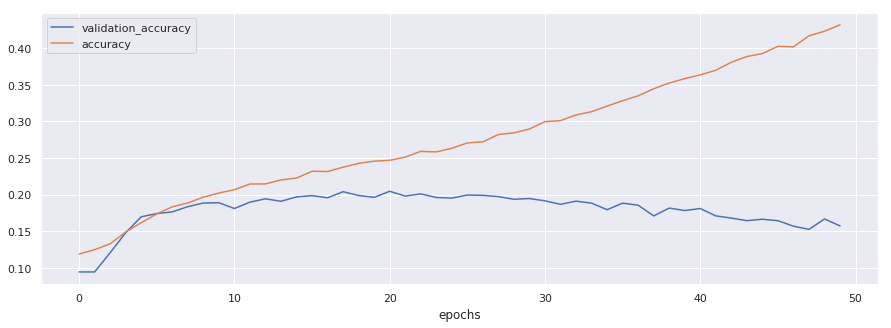

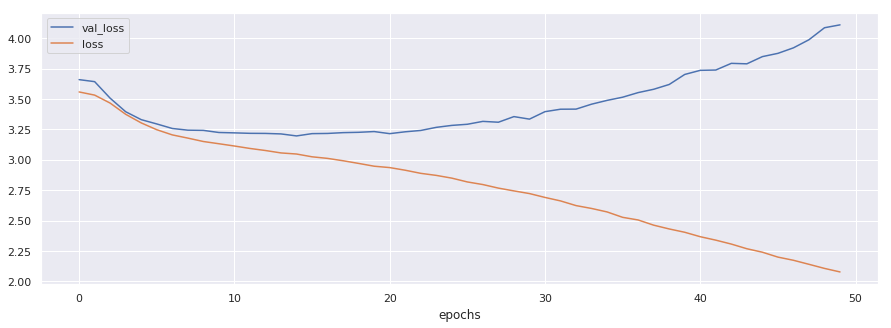

Final values
acc
0.12418743994205535
valacc
0.10747725173553911
loss
3.523310261081055
valoss
3.5892037471586113

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_167 (LSTM)              (None, 10, 256)           339968    
_________________________________________________________________
dropout_104 (Dropout)        (None, 10, 256)           0         
_________________________________________________________________
bidirectional_60 (Bidirectio (None, 10, 256)           394240    
_________________________________________________________________
lstm_169 (LSTM)              (None, 64)                82176     
_________________________________________________________________
dropout_105 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_60 (Dense)             (None, 75)                4875      
Total params: 821,259
Traina

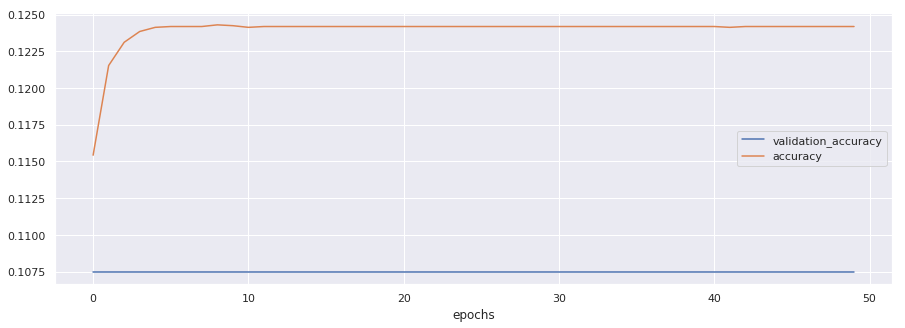

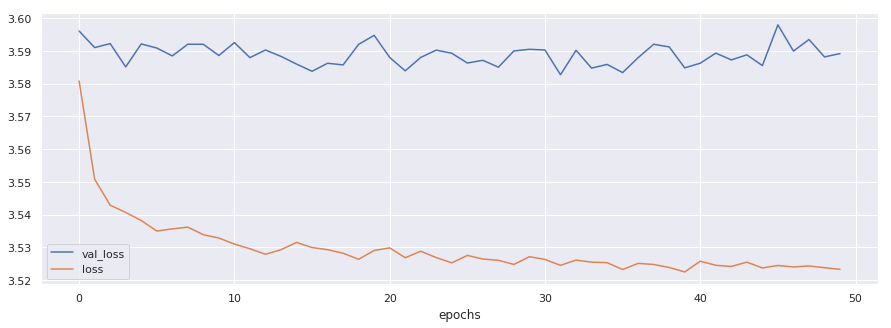

Final values
acc
0.2747296228144044
valacc
0.1690405539276574
loss
2.7780190055648935
valoss
3.4871336640283452

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_170 (LSTM)              (None, 10, 256)           339968    
_________________________________________________________________
dropout_106 (Dropout)        (None, 10, 256)           0         
_________________________________________________________________
bidirectional_61 (Bidirectio (None, 10, 256)           394240    
_________________________________________________________________
lstm_172 (LSTM)              (None, 64)                82176     
_________________________________________________________________
dropout_107 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_61 (Dense)             (None, 75)                4875      
Total params: 821,259
Trainab

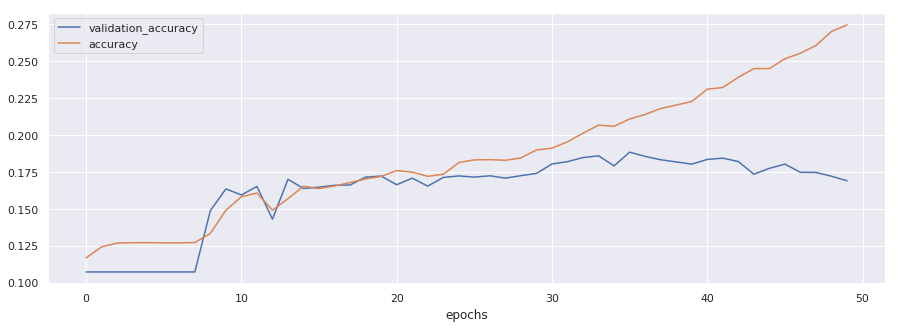

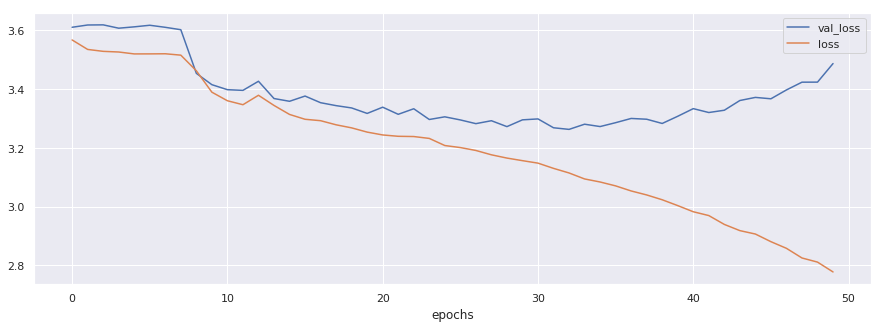

Final values
acc
0.48951491654565404
valacc
0.15478357205740342
loss
1.8090196102963716
valoss
4.289780553405851

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_173 (LSTM)              (None, 10, 256)           339968    
_________________________________________________________________
dropout_108 (Dropout)        (None, 10, 256)           0         
_________________________________________________________________
bidirectional_62 (Bidirectio (None, 10, 256)           394240    
_________________________________________________________________
lstm_175 (LSTM)              (None, 64)                82176     
_________________________________________________________________
dropout_109 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_62 (Dense)             (None, 75)                4875      
Total params: 821,259
Traina

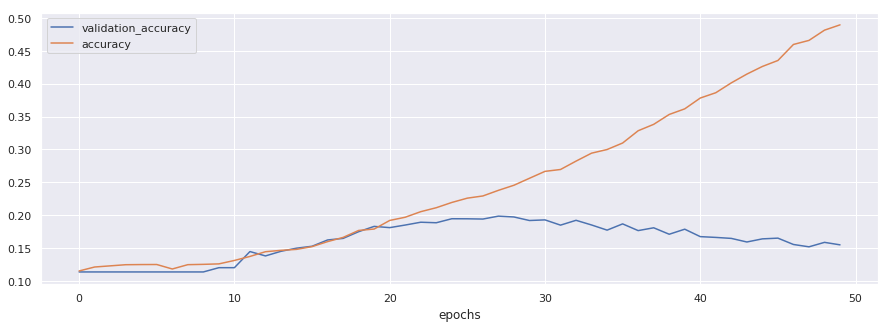

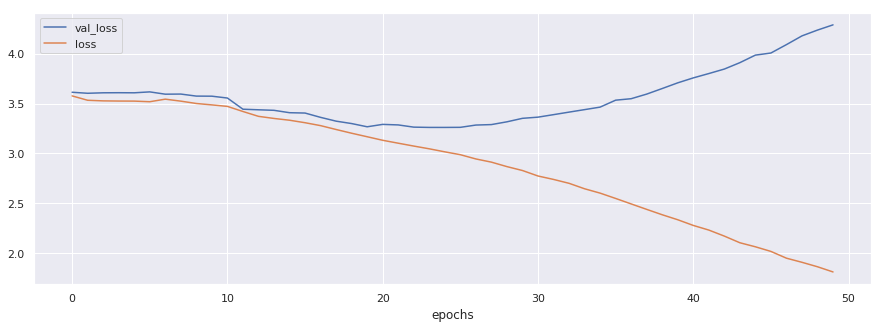

Final values
acc
0.6887921654443404
valacc
0.12700296735806785
loss
1.0862255492895763
valoss
5.6512062955052

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_176 (LSTM)              (None, 10, 256)           339968    
_________________________________________________________________
dropout_110 (Dropout)        (None, 10, 256)           0         
_________________________________________________________________
bidirectional_63 (Bidirectio (None, 10, 256)           394240    
_________________________________________________________________
lstm_178 (LSTM)              (None, 64)                82176     
_________________________________________________________________
dropout_111 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_63 (Dense)             (None, 75)                4875      
Total params: 821,259
Trainable

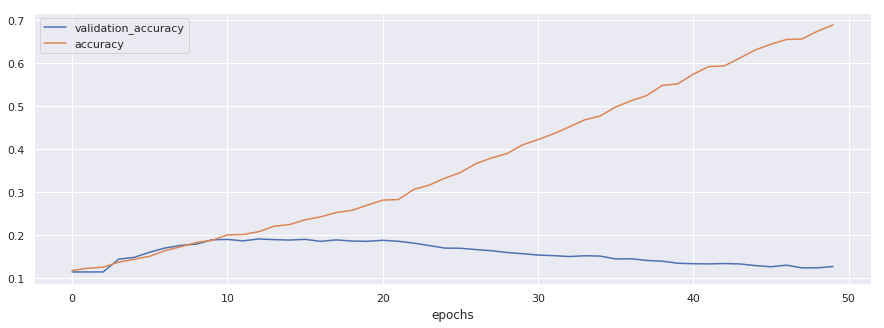

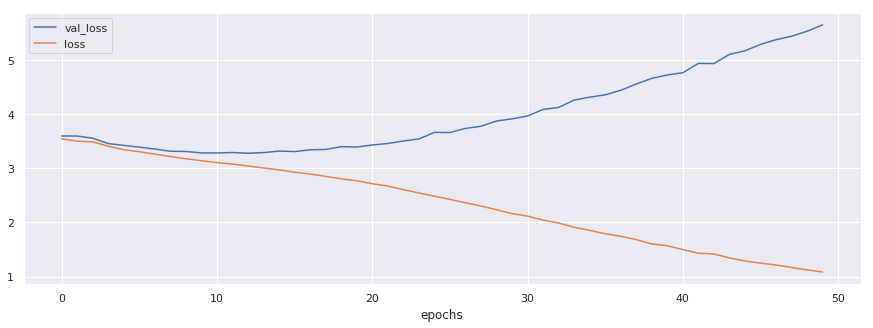

Final values
acc
0.1655236085740723
valacc
0.15402441781764653
loss
3.2335650093226533
valoss
3.4216847053728787

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_179 (LSTM)              (None, 10, 256)           339968    
_________________________________________________________________
dropout_112 (Dropout)        (None, 10, 256)           0         
_________________________________________________________________
bidirectional_64 (Bidirectio (None, 10, 256)           394240    
_________________________________________________________________
lstm_181 (LSTM)              (None, 64)                82176     
_________________________________________________________________
dropout_113 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_64 (Dense)             (None, 75)                4875      
Total params: 821,259
Traina

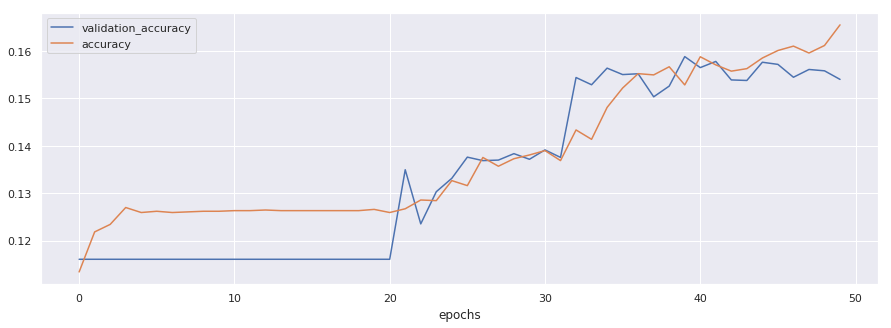

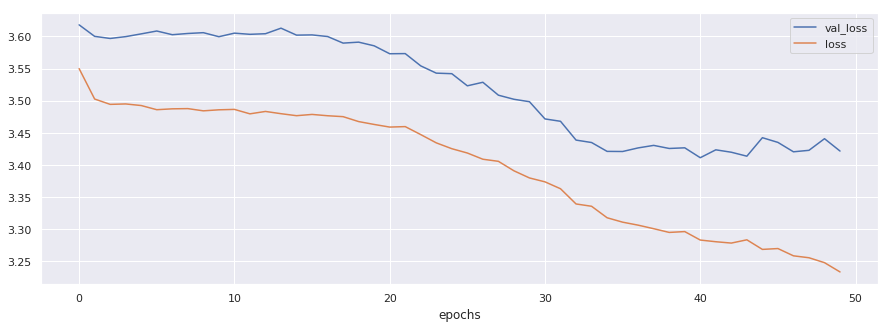

In [140]:
disp_results(h1)
disp_results(h2)
disp_results(h3)
disp_results(h4)
disp_results(h5)
disp_results(h6)
disp_results(h7)

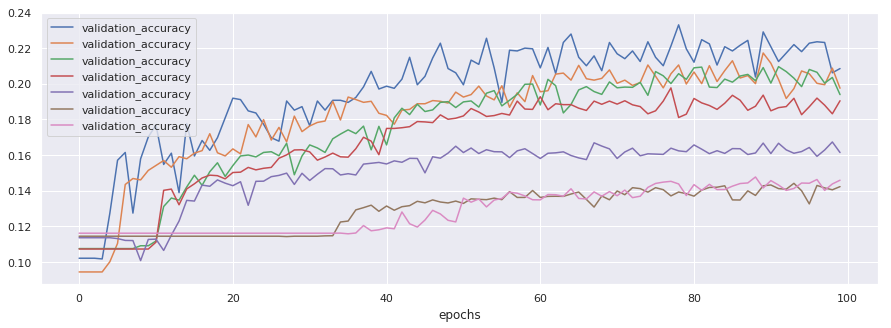

In [32]:
def history(h):
    history = h
    df = pd.DataFrame({'epochs': history.epoch,
                           'accuracy': history.history['acc'],
                           'validation_accuracy': history.history['val_acc'],
                           'loss': history.history['loss'], 
                           'val_loss': history.history['val_loss']})


        #Plot the the scores on the validation and training sets
    return df
fig, ax = plt.subplots()
history(h1).plot(x='epochs', y = ['validation_accuracy'], figsize=[15,5], ax=ax)
history(h2).plot(x='epochs', y = ['validation_accuracy'], figsize=[15,5], ax=ax)
history(h3).plot(x='epochs', y = ['validation_accuracy'], figsize=[15,5], ax=ax)
history(h4).plot(x='epochs', y = ['validation_accuracy'], figsize=[15,5], ax=ax)
history(h5).plot(x='epochs', y = ['validation_accuracy'], figsize=[15,5], ax=ax)
history(h6).plot(x='epochs', y = ['validation_accuracy'], figsize=[15,5], ax=ax)
history(h7).plot(x='epochs', y = ['validation_accuracy'], figsize=[15,5], ax=ax)

# Results

Using only chords, 100 epochs, lstm3
Final values
acc
0.9927296107621544
valacc
0.13313550934357649
loss
0.023922230613062003
valoss
7.8553825744417605

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, 10, 12)            912       
_________________________________________________________________
bidirectional_48 (Bidirectio (None, 10, 256)           144384    
_________________________________________________________________
bidirectional_49 (Bidirectio (None, 256)               394240    
_________________________________________________________________
dense_49 (Dense)             (None, 75)                19275     
Total params: 558,811
Trainable params: 558,811
Non-trainable params: 0
_________________________________________________________________
None


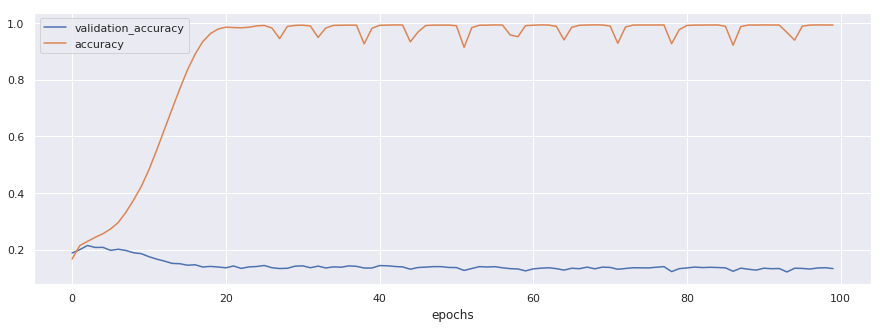

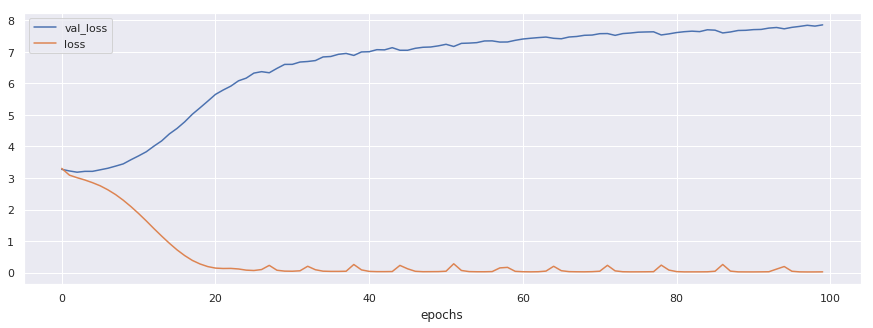

In [114]:
print("Using only chords, 100 epochs, lstm3")
disp_results(h3)

Using the time distributed version

Using all features, 300 epochs, lstm3
Final values
acc
0.9715614026705597
valacc
0.1372898120495733
loss
0.08930660636975903
valoss
8.895909447486039

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 10, 12)            4068      
_________________________________________________________________
bidirectional_46 (Bidirectio (None, 10, 256)           144384    
_________________________________________________________________
bidirectional_47 (Bidirectio (None, 256)               394240    
_________________________________________________________________
dense_47 (Dense)             (None, 75)                19275     
Total params: 561,967
Trainable params: 561,967
Non-trainable params: 0
_________________________________________________________________
None


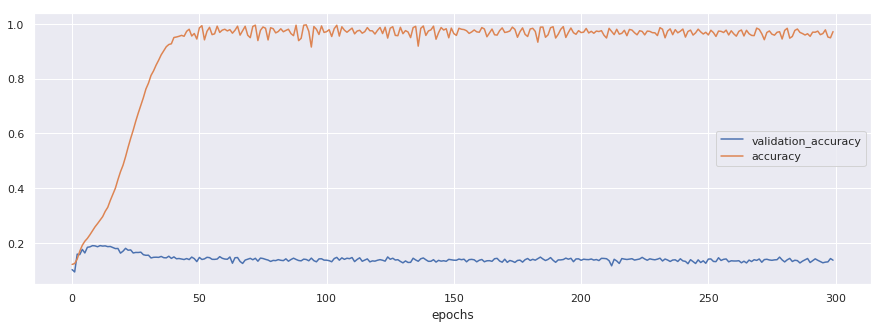

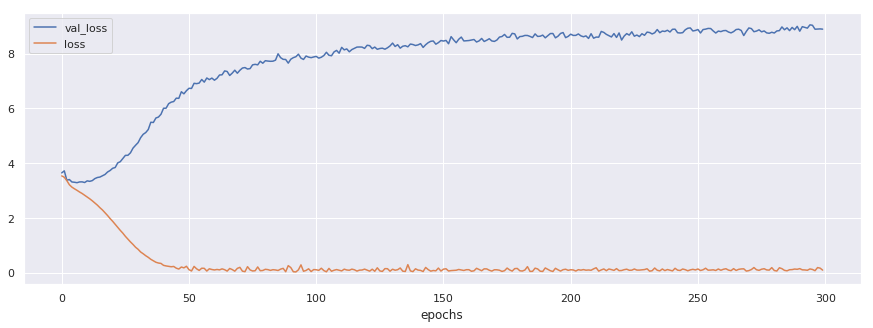

In [111]:
print("Using all features, 300 epochs, lstm3")
disp_results(h3)

### Training for 500 epochs

Using all features except chords, training for 500 epochs
Final values
acc
0.32301300757156176
valacc
0.17823936693982012
loss
2.4682189114069373
valoss
3.528936485060363

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_125 (LSTM)              (None, 10, 128)           200704    
_________________________________________________________________
dropout_80 (Dropout)         (None, 10, 128)           0         
_________________________________________________________________
bidirectional_42 (Bidirectio (None, 10, 128)           98816     
_________________________________________________________________
lstm_127 (LSTM)              (None, 32)                20608     
_________________________________________________________________
dropout_81 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 

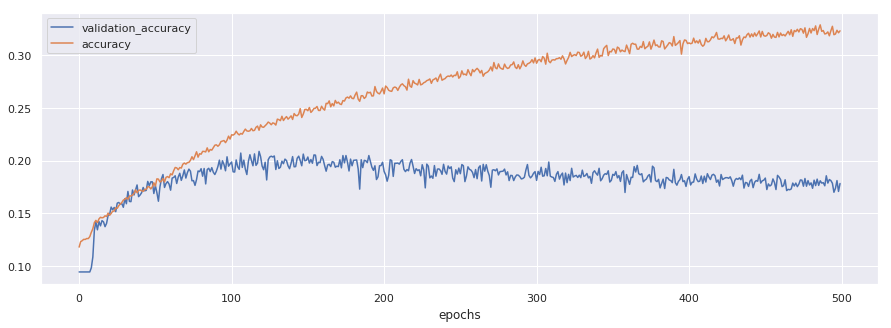

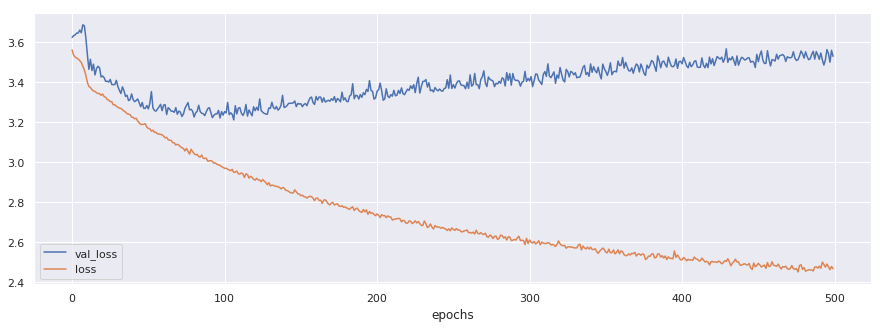

In [97]:
print("Using all features except chords, training for 500 epochs")
disp_results(h3)

### Primitive feature selection
What is best. Only chords, all features, all except chords?

Using only the chord feature
Final values
acc
0.4022948711460496
valacc
0.14025717109412278
loss
2.2165435983823487
valoss
4.454794151351431

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_113 (LSTM)              (None, 10, 128)           104448    
_________________________________________________________________
dropout_72 (Dropout)         (None, 10, 128)           0         
_________________________________________________________________
bidirectional_38 (Bidirectio (None, 10, 128)           98816     
_________________________________________________________________
lstm_115 (LSTM)              (None, 32)                20608     
_________________________________________________________________
dropout_73 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 75)                2475      


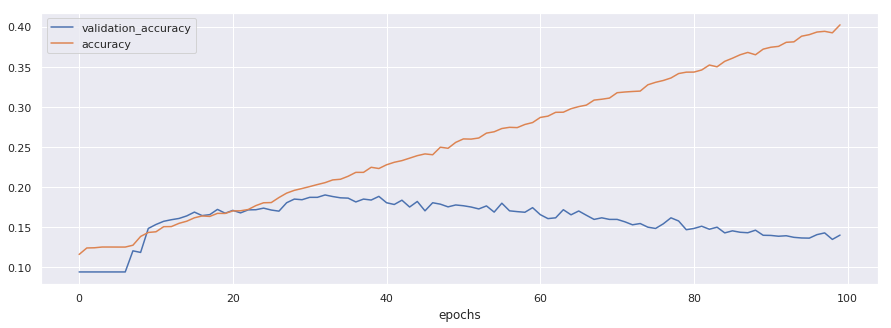

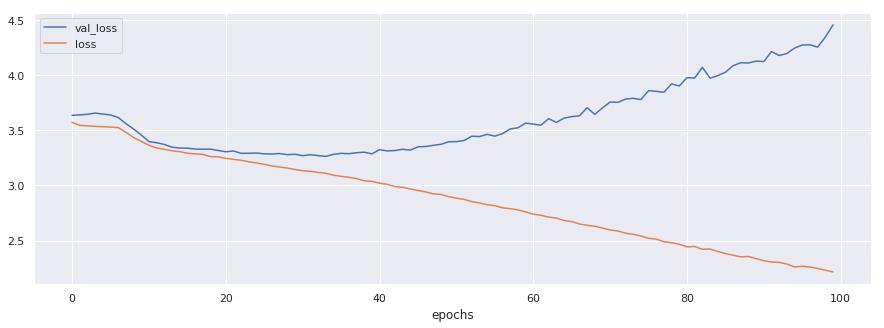

Using all features
Final values
acc
0.24091201345564095
valacc
0.19920870424142342
loss
2.9095368462197535
valoss
3.2357819291651544

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_116 (LSTM)              (None, 10, 128)           239104    
_________________________________________________________________
dropout_74 (Dropout)         (None, 10, 128)           0         
_________________________________________________________________
bidirectional_39 (Bidirectio (None, 10, 128)           98816     
_________________________________________________________________
lstm_118 (LSTM)              (None, 32)                20608     
_________________________________________________________________
dropout_75 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 75)                2475      
Total pa

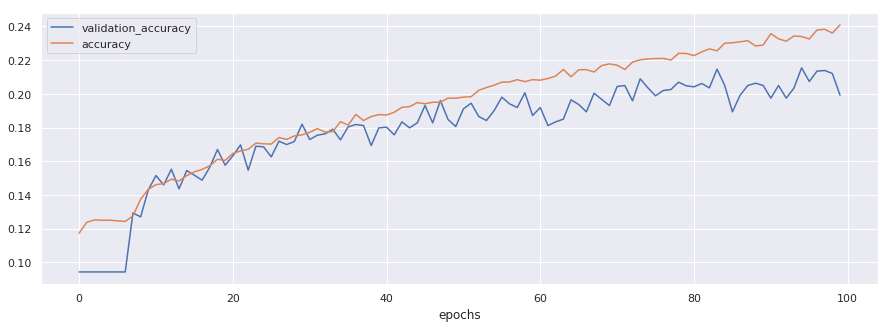

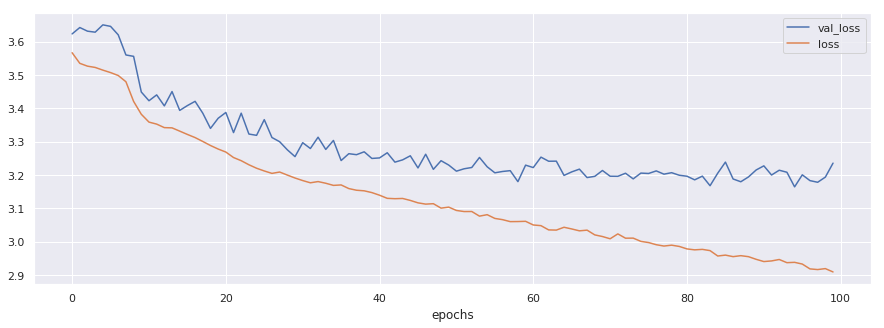

Using all features except chords
Final values
acc
0.2260250259494621
valacc
0.2025717111652612
loss
2.95196132054049
valoss
3.2145481655317054

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_119 (LSTM)              (None, 10, 128)           200704    
_________________________________________________________________
dropout_76 (Dropout)         (None, 10, 128)           0         
_________________________________________________________________
bidirectional_40 (Bidirectio (None, 10, 128)           98816     
_________________________________________________________________
lstm_121 (LSTM)              (None, 32)                20608     
_________________________________________________________________
dropout_77 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 75)                2475     

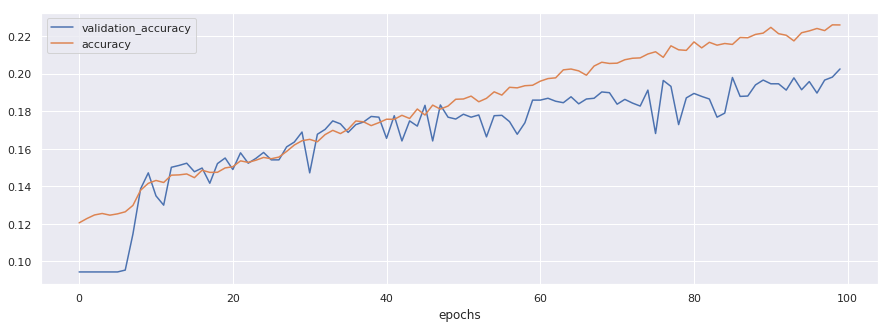

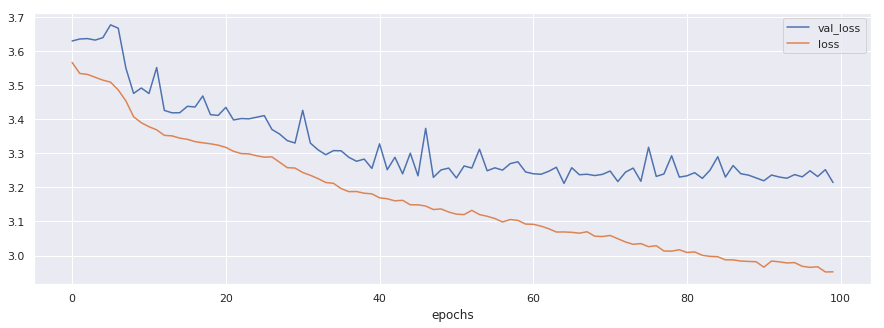

In [92]:
print("Using only the chord feature")
disp_results(h1)

print("Using all features")
disp_results(h2)

print("Using all features except chords")
disp_results(h3)


### Sequence lengths
Testing on sequence lenghts 5, 10, 20, 40, 80
Conclusions: Best with 10, marginal differences overall, significantly faster training with smaller sequences.

Final values
acc
0.18487645131149047
valacc
0.1522127405980036
loss
3.2899261492638048
valoss
3.598195571846422

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 160, 256)          513024    
_________________________________________________________________
dropout_15 (Dropout)         (None, 160, 256)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 160, 512)          1574912   
_________________________________________________________________
dropout_16 (Dropout)         (None, 160, 512)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_____________________________

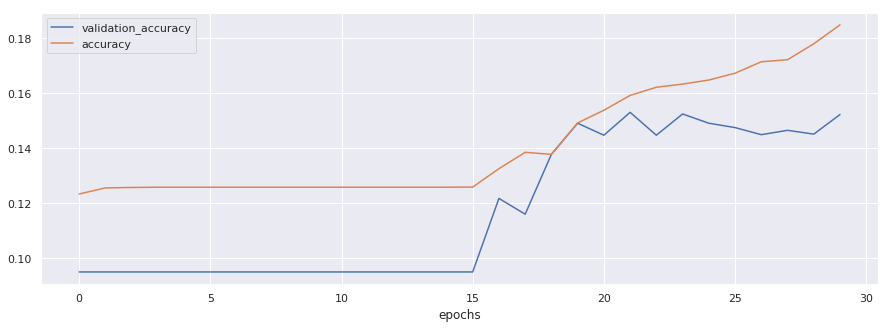

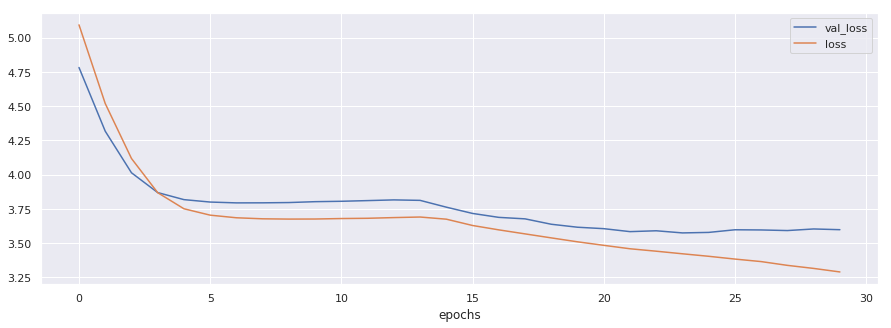

Final values
acc
0.21727047144922962
valacc
0.15839618893133928
loss
3.141557002150391
valoss
3.5978817542236254

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 160, 256)          513024    
_________________________________________________________________
dropout_15 (Dropout)         (None, 160, 256)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 160, 512)          1574912   
_________________________________________________________________
dropout_16 (Dropout)         (None, 160, 512)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
____________________________

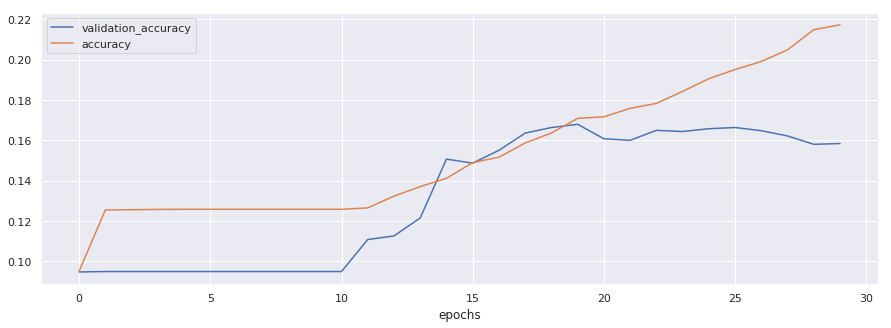

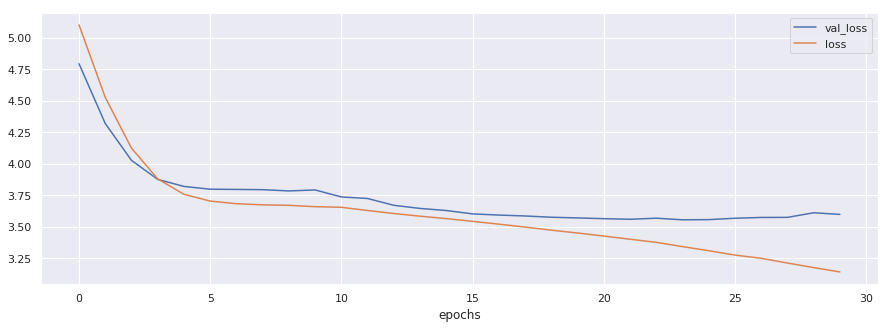

Final values
acc
0.16413464401260933
valacc
0.15031771248796802
loss
3.4155722475255472
valoss
3.5944106556102335

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 160, 256)          513024    
_________________________________________________________________
dropout_15 (Dropout)         (None, 160, 256)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 160, 512)          1574912   
_________________________________________________________________
dropout_16 (Dropout)         (None, 160, 512)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
___________________________

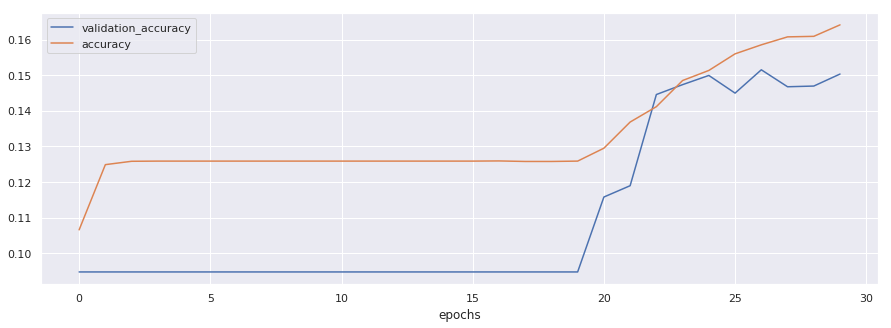

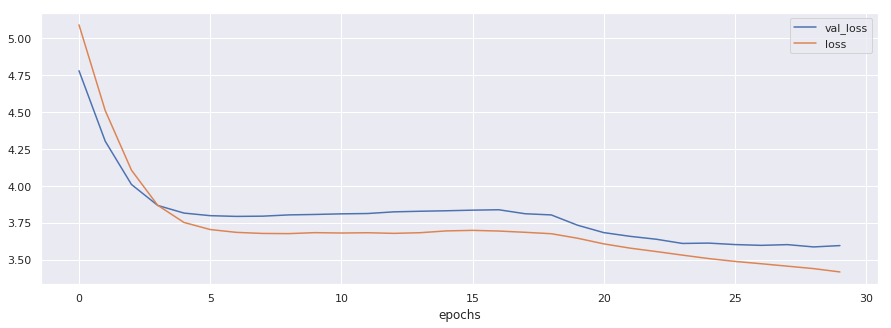

Final values
acc
0.18761800656312266
valacc
0.15441176470588236
loss
3.345946513408815
valoss
3.6128885901410173

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 160, 256)          513024    
_________________________________________________________________
dropout_15 (Dropout)         (None, 160, 256)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 160, 512)          1574912   
_________________________________________________________________
dropout_16 (Dropout)         (None, 160, 512)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
____________________________

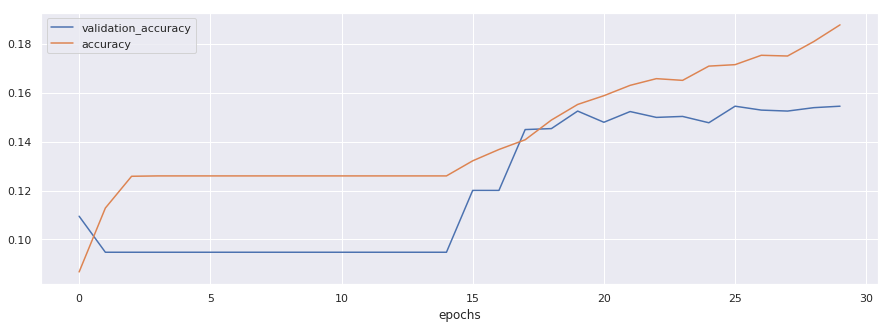

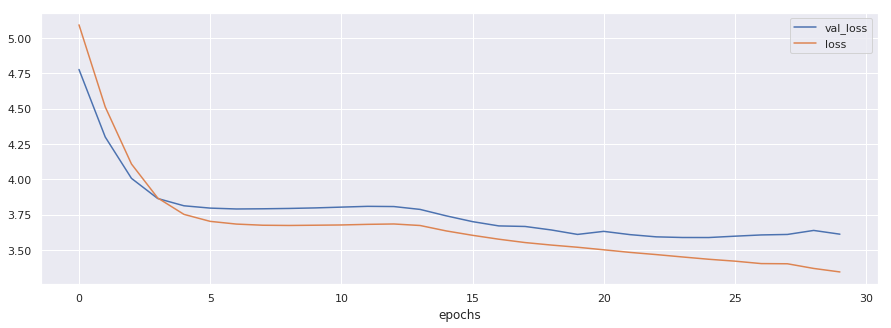

Final values
acc
0.14904946749235512
valacc
0.1429140127388535
loss
3.556054708363702
valoss
3.6760981447377783

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 160, 256)          513024    
_________________________________________________________________
dropout_15 (Dropout)         (None, 160, 256)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 160, 512)          1574912   
_________________________________________________________________
dropout_16 (Dropout)         (None, 160, 512)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_____________________________

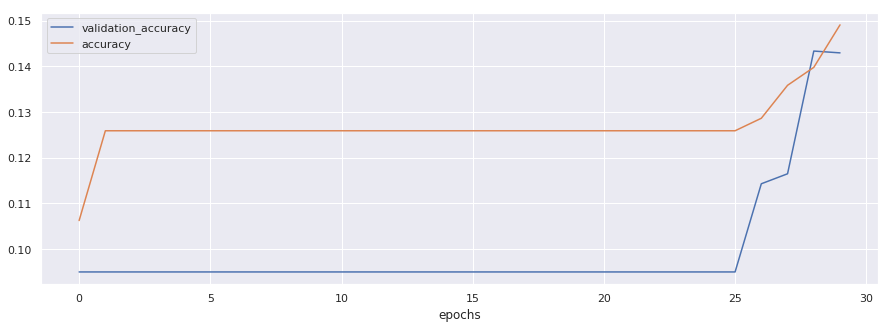

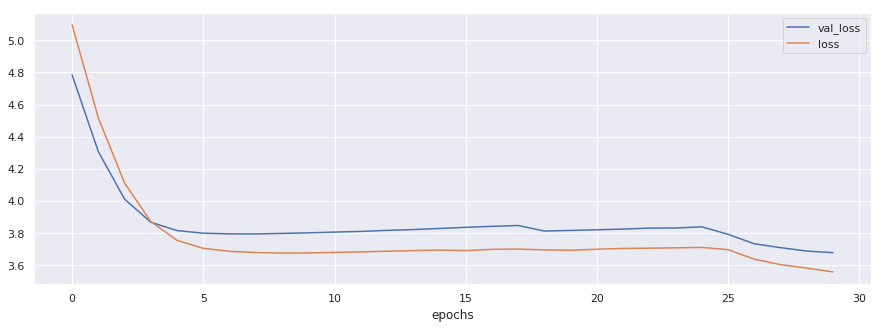

In [16]:
disp_results(h1)
disp_results(h2)
disp_results(h3)
disp_results(h4)
disp_results(h5)


In [28]:
#Save weights
h1.model.save("h1.hdf5")
h2.model.save("h2.hdf5")
h3.model.save("h3.hdf5")
h4.model.save("h4.hdf5")
h5.model.save("h5.hdf5")

### Training for 100 epochs using only the chords feature


Final values
acc
0.7754342432530879
valacc
0.11055974594571373
loss
0.8889608065602798
valoss
5.647335171178959

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 10, 256)           513024    
_________________________________________________________________
dropout_18 (Dropout)         (None, 10, 256)           0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 10, 512)           1574912   
_________________________________________________________________
dropout_19 (Dropout)         (None, 10, 512)           0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_12 (Dense)             (None, 256)               65792     
_____________________________

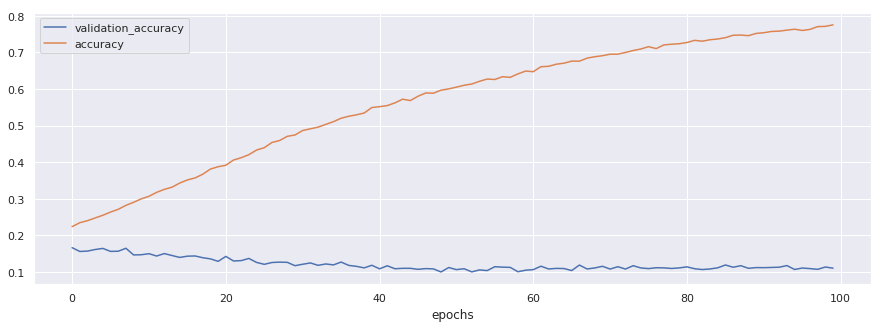

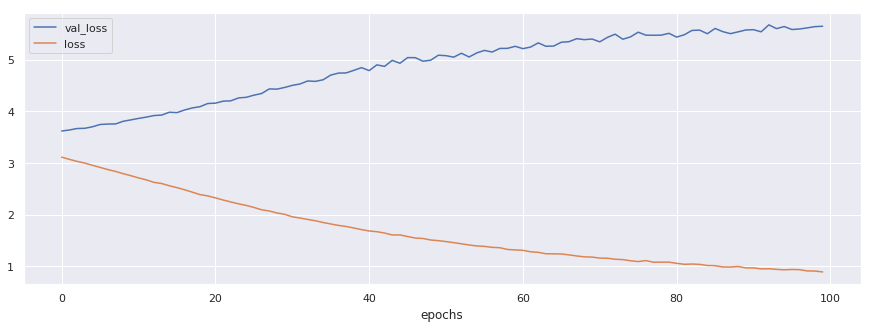

In [31]:
disp_results(h6)
h6.model.save("h6.hdf5")

### Training for 100 epochs using ALL features


Final values
acc
0.6240694788608598
valacc
0.1129416435034136
loss
1.402275422358927
valoss
5.05821556191257

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10, 256)           800768    
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 256)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 512)           1574912   
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 512)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
________________________________

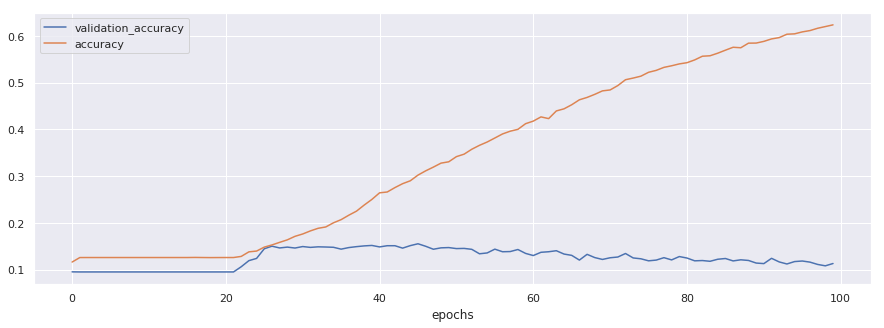

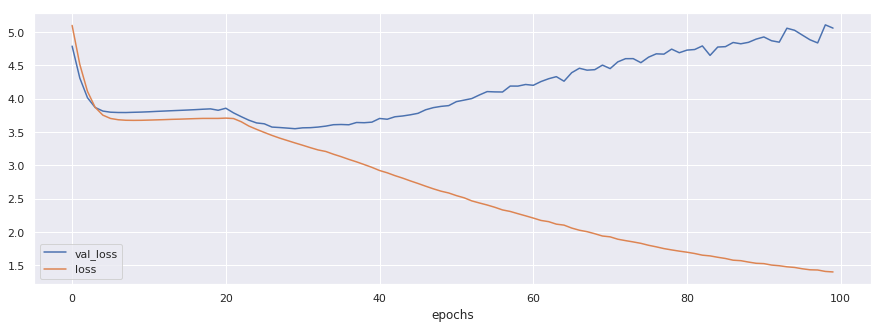

In [9]:
disp_results(h7)
h7.model.save("h7.hdf5")